In [1]:
# evaluation of models on the test set

import os
import numpy as np
import pandas as pd
import glob
import re
from scipy.special import softmax

from scipy.io import loadmat
from skimage.transform import resize
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, accuracy_score
import PIL.Image as Image
import matplotlib.pyplot as plt

from platt_scaling import platt_scaling_fit
from conformal_pred_algos import *
from conformal_pred_metrics import *

In [2]:
def LoadImage(file_path):
    im = Image.open(file_path)
    im = np.asarray(im)/255
    return im

def ShowGrayscaleImage(file_path, title='', ax=None):
    
    im = Image.open(file_path)
    im.show()
#     if ax is None:
#         plt.figure()
#     plt.axis('off')
#     plt.imshow(im , cmap=plt.cm.gray, vmin=0, vmax=1) #im is of float, 0-1
#     plt.title(title)
    
def get_TMED_image_by_id(uid):
    ShowGrayscaleImage(uid)

In [3]:
dataset = 'TMED'
if dataset == 'TMED':
    methods = ['Default', 'LE=1']
    log_root = "../logs/"
    val_csvs = ["tmed_high_lr/round0/csvs/val_12_0.58.csv", "tmed_high_lr/round1/csvs/val_14_0.65.csv"]
    test_csvs = ["tmed_high_lr/round0/csvs/test_15_0.60.csv", "tmed_high_lr/round1/csvs/test_15_0.61.csv"]
    
    view_log_root = "../logs/R18_tmed_view/csvs/"
    view_val_csv = view_log_root + "val_28_0.86.csv"
    view_test_csv = view_log_root + "test_30_0.86.csv"
    
    val_csvs = [log_root + m for m in val_csvs]
    test_csvs = [log_root + m for m in test_csvs]

In [4]:
# collect the dataframes
df_val = [pd.read_csv(x) for x in val_csvs]
df_test = [pd.read_csv(x) for x in test_csvs]
df_view_val = pd.read_csv(view_val_csv)
df_view_test = pd.read_csv(view_test_csv)

In [5]:
df_val[0]

,Unnamed: 0,filename,y,outputs_0,outputs_1,outputs_2
0,0,/data/TMED/approved_users_only/view_and_diagno...,2,1.664437,-6.069416,3.576227
1,1,/data/TMED/approved_users_only/view_and_diagno...,2,-7.693852,2.053133,3.239326
2,2,/data/TMED/approved_users_only/view_and_diagno...,2,-3.415044,1.684520,0.185808
3,3,/data/TMED/approved_users_only/view_and_diagno...,2,-3.697043,0.542567,1.451734
4,4,/data/TMED/approved_users_only/view_and_diagno...,2,-3.975106,2.219419,0.083989
...,...,...,...,...,...,...
3597,3597,/data/TMED/approved_users_only/view_and_diagno...,1,-0.595184,-3.493111,2.974856
3598,3598,/data/TMED/approved_users_only/view_and_diagno...,1,-2.332581,-2.781833,3.652832
3599,3599,/data/TMED/approved_users_only/view_and_diagno...,1,-3.702657,-2.329664,4.270867
3600,3600,/data/TMED/approved_users_only/view_and_diagno...,1,-7.233850,1.786338,3.092496


In [6]:
df_view_val

,Unnamed: 0,filename,y,outputs_0,outputs_1,outputs_2,outputs_3,outputs_4
0,0,/data/TMED/approved_users_only/view_and_diagno...,2,-4.474420,-3.293290,6.873021,-0.333446,1.616674
1,1,/data/TMED/approved_users_only/view_and_diagno...,2,-3.309696,-2.830891,8.621917,-2.180509,-0.649588
2,2,/data/TMED/approved_users_only/view_and_diagno...,1,2.004665,3.165979,-3.395484,-3.794709,1.437607
3,3,/data/TMED/approved_users_only/view_and_diagno...,1,-0.827677,0.754046,0.219749,-3.265019,3.110798
4,4,/data/TMED/approved_users_only/view_and_diagno...,1,0.029023,5.757953,-2.896789,-3.963840,0.544494
...,...,...,...,...,...,...,...,...
3597,3597,/data/TMED/approved_users_only/view_and_diagno...,2,-4.372354,-6.356860,11.311464,-0.824119,0.978929
3598,3598,/data/TMED/approved_users_only/view_and_diagno...,2,-5.248043,-3.611111,9.580708,0.401862,-0.767299
3599,3599,/data/TMED/approved_users_only/view_and_diagno...,1,-3.988742,6.446634,-3.618449,-2.065079,3.083159
3600,3600,/data/TMED/approved_users_only/view_and_diagno...,3,-3.226174,-5.905871,-2.053742,9.711393,2.308455


In [7]:
def df_to_logits(df):
    # take the outputs_x rows and conver them to array of (N, C)
    cols = [x for x in df.columns if 'outputs' in x]
    logits = df[cols].to_numpy()
    return logits

test_logits = [df_to_logits(x) for x in df_test]
val_logits = [df_to_logits(x) for x in df_val]

test_view_logits = df_to_logits(df_view_test)
val_view_logits = df_to_logits(df_view_val)

In [8]:
def get_calibration_data(sm, y):
    # sm is N, C softmax output
    # compute the accuracy of each confidence decile
    confidences = np.max(sm, axis=1)
    preds = np.argmax(sm, axis=1)
    #print(confidences)
    confidence_hist, bin_edges = np.histogram(confidences, bins=np.arange(11)/10)
    #print(confidence_hist)
    #print(bin_edges)
    bin_association = np.digitize(confidences, bins=bin_edges)
    #print(np.unique(bin_association))
    calibration_x = []
    calibration_y = []
    ECE = 0
    for i in range(10):
        subset = bin_association == (i+1)
        if confidence_hist[i] > 0:
            acc = accuracy_score(y[subset], preds[subset])
            calibration_x.append(i)
            calibration_y.append(acc)
            #print(np.mean(confidences[subset]))
            # calculate ECE
            ECE += confidence_hist[i] * np.abs(acc - np.mean(confidences[subset]))
    ECE = ECE / len(y)
    
    return calibration_x, calibration_y, ECE

In [9]:
# obtain confidences from the logits for each dataframe
calibrate_diagnosis = False
calibrate_view = False

def get_preds_from_logits(val_logits, test_logits, val_y, platt=True):
    if platt:
        platt_coeffs = platt_scaling_fit(val_logits, val_y, mode="temp")
        test_preds = softmax(test_logits*platt_coeffs, axis=1)
        val_preds = softmax(val_logits*platt_coeffs, axis=1)
    else:
        test_preds = softmax(test_logits, axis=1)
        val_preds = softmax(val_logits, axis=1)

    return test_preds, val_preds
        
test_preds = []
val_preds = []
for i in range(len(methods)):
    t, v = get_preds_from_logits(val_logits[i], test_logits[i], df_val[i]['y'], platt=calibrate_diagnosis)
    _, _, ece = get_calibration_data(t, df_test[i]['y'])
    print(f"Method = {methods[i]}, Platt = {calibrate_diagnosis}, ECE = {ece}")
    test_preds.append(t)
    val_preds.append(v)
    
test_view_preds, val_view_preds = get_preds_from_logits(val_view_logits, test_view_logits, df_view_val['y'], platt=calibrate_view)
_, _, ece = get_calibration_data(test_view_preds, df_view_test['y'])
print(f"View, Platt = {calibrate_view}, ECE = {ece}")

Method = Default, Platt = False, ECE = 0.1419936363826432
Method = LE=1, Platt = False, ECE = 0.02435712316437258
View, Platt = False, ECE = 0.0859936476597173


In [10]:
# put the preds back into the val/test dataframes
def add_pred_columns_to_df(df, preds):
    for j in range(preds.shape[1]):
        df[f'preds_{j}'] = preds[:, j]

for i in range(len(methods)):
    add_pred_columns_to_df(df_test[i], test_preds[i])
    add_pred_columns_to_df(df_val[i], val_preds[i])

add_pred_columns_to_df(df_view_test, test_view_preds)
add_pred_columns_to_df(df_view_val, val_view_preds)

In [11]:
df_test[0]

,Unnamed: 0,filename,y,outputs_0,outputs_1,outputs_2,preds_0,preds_1,preds_2
0,0,/data/TMED/approved_users_only/view_and_diagno...,2,-4.357737,4.076598,-1.191372,2.161167e-04,0.994657,0.005127
1,1,/data/TMED/approved_users_only/view_and_diagno...,2,-6.257405,7.044814,-2.533562,1.670663e-06,0.999929,0.000069
2,2,/data/TMED/approved_users_only/view_and_diagno...,2,-8.174859,6.931254,-0.878789,2.749933e-07,0.999594,0.000405
3,3,/data/TMED/approved_users_only/view_and_diagno...,2,-4.265769,1.858843,0.925698,1.568138e-03,0.716587,0.281844
4,4,/data/TMED/approved_users_only/view_and_diagno...,2,-5.907566,-0.029820,3.759064,6.195760e-05,0.022119,0.977819
...,...,...,...,...,...,...,...,...,...
3597,3597,/data/TMED/approved_users_only/view_and_diagno...,2,-4.245203,-4.566029,6.791389,1.610115e-05,0.000012,0.999972
3598,3598,/data/TMED/approved_users_only/view_and_diagno...,2,-6.036833,-1.195459,5.006837,1.595546e-05,0.002021,0.997963
3599,3599,/data/TMED/approved_users_only/view_and_diagno...,2,-3.758008,-3.493092,5.433960,1.018303e-04,0.000133,0.999765
3600,3600,/data/TMED/approved_users_only/view_and_diagno...,2,-1.842666,-4.635487,5.148268,9.192894e-04,0.000056,0.999024


In [12]:
df_view_val

,Unnamed: 0,filename,y,outputs_0,outputs_1,outputs_2,outputs_3,outputs_4,preds_0,preds_1,preds_2,preds_3,preds_4
0,0,/data/TMED/approved_users_only/view_and_diagno...,2,-4.474420,-3.293290,6.873021,-0.333446,1.616674,1.172919e-05,3.821436e-05,0.994030,0.000737,0.005183
1,1,/data/TMED/approved_users_only/view_and_diagno...,2,-3.309696,-2.830891,8.621917,-2.180509,-0.649588,6.578234e-06,1.061822e-05,0.999868,0.000020,0.000094
2,2,/data/TMED/approved_users_only/view_and_diagno...,1,2.004665,3.165979,-3.395484,-3.794709,1.437607,2.096935e-01,6.697879e-01,0.000947,0.000635,0.118936
3,3,/data/TMED/approved_users_only/view_and_diagno...,1,-0.827677,0.754046,0.219749,-3.265019,3.110798,1.662751e-02,8.086502e-02,0.047393,0.001453,0.853661
4,4,/data/TMED/approved_users_only/view_and_diagno...,1,0.029023,5.757953,-2.896789,-3.963840,0.544494,3.221790e-03,9.911514e-01,0.000173,0.000059,0.005395
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3597,3597,/data/TMED/approved_users_only/view_and_diagno...,2,-4.372354,-6.356860,11.311464,-0.824119,0.978929,1.543789e-07,2.121915e-08,0.999962,0.000005,0.000033
3598,3598,/data/TMED/approved_users_only/view_and_diagno...,2,-5.248043,-3.611111,9.580708,0.401862,-0.767299,3.629908e-07,1.865546e-06,0.999863,0.000103,0.000032
3599,3599,/data/TMED/approved_users_only/view_and_diagno...,1,-3.988742,6.446634,-3.618449,-2.065079,3.083159,2.838446e-05,9.662883e-01,0.000041,0.000194,0.033448
3600,3600,/data/TMED/approved_users_only/view_and_diagno...,3,-3.226174,-5.905871,-2.053742,9.711393,2.308455,2.404458e-06,1.649070e-07,0.000008,0.999381,0.000609


### Perform image-level analysis on PLAX and PSAX images only

In [13]:
# perform image-level analysis on PLAX and PSAX images only
def filter_preds_by_view(df, df_view):
    view_labels = df_view['y'].to_numpy()
    key_view_mask = (view_labels == 2) | (view_labels == 3)
    
    return df[key_view_mask]

#filter_preds_by_view(df_view_val, df_view_val)['y'].value_counts()
df_val_filtered = [filter_preds_by_view(x, df_view_val).reset_index() for x in df_val]
df_test_filtered = [filter_preds_by_view(x, df_view_val).reset_index() for x in df_val]

In [14]:
df_test_filtered[0]

,index,Unnamed: 0,filename,y,outputs_0,outputs_1,outputs_2,preds_0,preds_1,preds_2
0,0,0,/data/TMED/approved_users_only/view_and_diagno...,2,1.664437,-6.069416,3.576227,0.128773,0.000056,0.871171
1,1,1,/data/TMED/approved_users_only/view_and_diagno...,2,-7.693852,2.053133,3.239326,0.000014,0.233937,0.766049
2,19,19,/data/TMED/approved_users_only/view_and_diagno...,2,-1.969402,-1.616029,2.345114,0.012953,0.018444,0.968603
3,20,20,/data/TMED/approved_users_only/view_and_diagno...,2,-6.547378,-1.023649,5.359385,0.000007,0.001687,0.998306
4,21,21,/data/TMED/approved_users_only/view_and_diagno...,2,-4.119503,-1.974785,4.353608,0.000209,0.001781,0.998010
...,...,...,...,...,...,...,...,...,...,...
1305,3595,3595,/data/TMED/approved_users_only/view_and_diagno...,1,-3.857192,-0.454538,2.689405,0.001374,0.041274,0.957352
1306,3596,3596,/data/TMED/approved_users_only/view_and_diagno...,1,0.381024,-5.036017,3.639841,0.037005,0.000164,0.962830
1307,3597,3597,/data/TMED/approved_users_only/view_and_diagno...,1,-0.595184,-3.493111,2.974856,0.027342,0.001508,0.971150
1308,3598,3598,/data/TMED/approved_users_only/view_and_diagno...,1,-2.332581,-2.781833,3.652832,0.002505,0.001598,0.995897


In [15]:
# compute the top-1 balanced accuracy
for i in range(len(methods)):
    output_cols = [x for x in df_test_filtered[i].columns if 'preds' in x]
    test_gt = df_test_filtered[i]['y']#test_y_study_level[i]
    test_preds = df_test_filtered[i][output_cols].to_numpy()
    test_pred = np.argmax(test_preds, axis=1)
    
    test_acc = balanced_accuracy_score(test_gt, test_pred)
    print(f"Method: {methods[i]}, balanced top-1 acc = {test_acc}")
    print(confusion_matrix(test_gt, test_pred))

Method: Default, balanced top-1 acc = 0.6095376968242244
[[166  37  83]
 [ 18  94  75]
 [ 49 164 624]]
Method: LE=1, balanced top-1 acc = 0.6608308059920963
[[207  33  46]
 [ 22 102  63]
 [103 137 597]]


In [19]:
# Conformal prediction using LABEL
confidences, pred_classes, css, = [], [], []

for i in range(len(methods)):
    print(methods[i])
    y_test = df_test_filtered[i]['y'].to_numpy()
    y_val = df_val_filtered[i]['y'].to_numpy()
    
    output_cols = [x for x in df_test_filtered[i].columns if 'preds' in x]
    val_sm = df_val_filtered[i][output_cols].to_numpy()
    test_sm = df_test_filtered[i][output_cols].to_numpy()
    
    # evaluate the median of many conformal prediction splits
    cov, bcov, card = develop_coverage_distribution(y_test, test_sm, n_splits=100, test_size=0.5, alpha=0.1)
    
    print(f"cov: {np.median(cov)}, {np.std(cov)}")
    print(f"bcov: {np.median(bcov)}, {np.std(bcov)}")
    print(f"card: {np.median(card)}, {np.std(card)}")
    
    # record down the conformal prediction sets from one split

    alpha = 0.1
    qhat = LABEL_fit(y_val, val_sm, alpha, verbose=False)
    cs = LABEL_inference(test_sm,  qhat)

#     cov = coverage_test(y_test, cs)
#     bcov = balanced_coverage_test(y_test, cs)
#     card = cardinality_test(cs)
#     if dataset != 'CIFAR':
#         print(ordinality_test_arr(cs))
#    print(f"Method {methods[i]} alpha={alpha}: cov={cov}, bcov={bcov}, card={card}, efficiency={bcov/card}")
    
    confidences.append(test_sm)
    pred_classes.append(np.argmax(test_sm, axis=1))
    css.append(cs)

Default
cov: 0.9038167938931297, 0.017136682009282877
bcov: 0.9031116907812966, 0.017750456332267583
card: 1.9931297709923665, 0.08405450239574862
LE=1
cov: 0.9015267175572519, 0.01608630067484598
bcov: 0.903299635283588, 0.019647489503414856
card: 1.9015267175572519, 0.07247259096214825


In [20]:
# show some examples for inference
def show_inference_data(index, verbose=False):
    name = df_test_filtered[0]['filename'][index]
    label = df_test_filtered[0]['y'][index]
    class_mapping = np.array(['no AS', 'early AS', 'significant AS'])
    print(f"Name: {name}, GT: {class_mapping[label]}")
    for i in range(2):
        conformal_set = css[i][index]
        indices = np.where(conformal_set)[0]
        local_conf = confidences[i][index][indices]
        if verbose:
            print(f"Method {methods[i]}, classes = {class_mapping[indices]}, confidences = {local_conf}")
    return

show_inference_data(0, True)


Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/3532s1_0.png, GT: significant AS
Method Default, classes = ['no AS' 'significant AS'], confidences = [0.12877255 0.87117108]
Method LE=1, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.26163059 0.30229375 0.43607566]


In [21]:
N = len(pred_classes[0])
ce_pred = pred_classes[0]
rt_pred = pred_classes[1]
gt = df_test_filtered[0]['y'].to_numpy(dtype=int)
cond = (gt != rt_pred) & (gt != ce_pred)

selected = np.where(cond)[0]
# # sort where by the discrepancy between predictions for the right class
#confidence_differences = confidences[1][range(N), gt] - confidences[0][range(N), gt]
#confidence_differences = confidence_differences[selected]
#conf1 = confidences[1][range(N), gt]
#conf1 = conf1[selected]
#selected = selected[np.argsort(conf1)]
print(selected)

[   9   10   14   18   21   49   50   92   93   94   95   96   97  117
  118  135  136  137  138  139  140  141  143  151  156  158  159  160
  161  162  163  164  165  169  171  173  174  177  181  187  193  202
  207  213  218  219  220  221  223  227  250  264  275  283  284  285
  286  303  306  307  308  311  312  313  314  315  317  319  322  331
  335  363  366  373  399  414  415  416  417  422  427  432  435  436
  438  439  441  443  444  445  446  448  454  475  476  478  500  502
  508  509  510  514  533  565  566  567  578  608  621  623  624  675
  676  677  680  681  682  691  694  713  714  717  734  737  739  764
  772  780  788  794  808  809  810  811  812  813  816  817  825  829
  841  850  852  853  857  858  860  861  864  865  881  883  884  890
  891  894  897  898  901  912  914  920  922  923  924  926  927  928
  933  935  936  937  946  948  950  953  956  965  970  973  993 1002
 1003 1006 1021 1023 1044 1047 1048 1050 1052 1055 1057 1058 1059 1061
 1075 

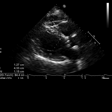

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/3532s1_26.png, GT: significant AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.61627395 0.3837257 ]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.59306559 0.32660257]


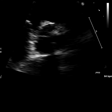

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/1991s1_4.png, GT: significant AS
Method Default, classes = ['no AS' 'significant AS'], confidences = [0.97224373 0.02770848]
Method LE=1, classes = ['no AS' 'significant AS'], confidences = [0.75510873 0.19379494]


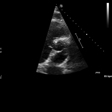

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/1991s1_30.png, GT: significant AS
Method Default, classes = ['no AS' 'significant AS'], confidences = [0.93758709 0.06071037]
Method LE=1, classes = ['no AS' 'significant AS'], confidences = [0.74341885 0.20070662]


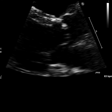

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/1991s1_39.png, GT: significant AS
Method Default, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.6129902  0.10564136 0.28136843]
Method LE=1, classes = ['no AS' 'significant AS'], confidences = [0.53660438 0.33630822]


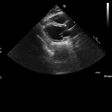

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/1991s1_42.png, GT: significant AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.98020255 0.01402008]
Method LE=1, classes = ['early AS'], confidences = [0.70220759]


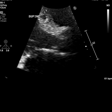

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/3181s1_17.png, GT: significant AS
Method Default, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.01737711 0.8637486  0.11887429]
Method LE=1, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.39192993 0.35263025 0.25543983]


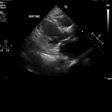

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/3181s1_18.png, GT: significant AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.6830629  0.31448065]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.49283923 0.42639024]


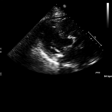

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/2142s1_1.png, GT: no AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.88219566 0.11780393]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.63272989 0.28883002]


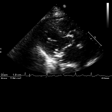

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/2142s1_2.png, GT: no AS
Method Default, classes = ['significant AS'], confidences = [0.9952309]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.49297172 0.4559143 ]


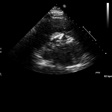

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/2142s1_3.png, GT: no AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.28511299 0.71367627]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.60109918 0.22512826]


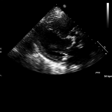

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/2142s1_8.png, GT: no AS
Method Default, classes = ['early AS'], confidences = [0.99557518]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.63290647 0.32374316]


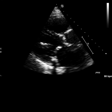

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/2142s1_9.png, GT: no AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.09764586 0.90138768]
Method LE=1, classes = ['significant AS'], confidences = [0.72529652]


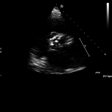

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/2142s1_10.png, GT: no AS
Method Default, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.09928357 0.34336225 0.55735418]
Method LE=1, classes = ['significant AS'], confidences = [0.85612729]


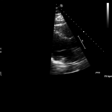

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/161s2_4.png, GT: no AS
Method Default, classes = ['no AS' 'significant AS'], confidences = [0.02290239 0.97708767]
Method LE=1, classes = ['no AS' 'significant AS'], confidences = [0.20983962 0.75647562]


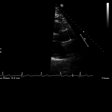

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/161s2_5.png, GT: no AS
Method Default, classes = ['no AS' 'significant AS'], confidences = [0.14073307 0.85926348]
Method LE=1, classes = ['no AS' 'significant AS'], confidences = [0.4225739  0.56816933]


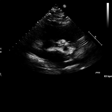

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/1777s1_11.png, GT: early AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.04849636 0.95146671]
Method LE=1, classes = ['no AS' 'early AS'], confidences = [0.68597842 0.21409992]


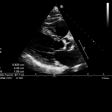

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/1777s1_12.png, GT: early AS
Method Default, classes = ['significant AS'], confidences = [0.99770014]
Method LE=1, classes = ['significant AS'], confidences = [0.83092467]


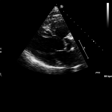

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/1777s1_13.png, GT: early AS
Method Default, classes = ['significant AS'], confidences = [0.99685499]
Method LE=1, classes = ['no AS' 'significant AS'], confidences = [0.50249461 0.40721303]


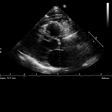

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/1777s1_14.png, GT: early AS
Method Default, classes = ['no AS' 'significant AS'], confidences = [0.01601632 0.98397104]
Method LE=1, classes = ['significant AS'], confidences = [0.72039819]


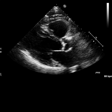

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/1777s1_15.png, GT: early AS
Method Default, classes = ['significant AS'], confidences = [0.99760884]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.19659401 0.67668104]


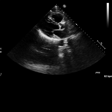

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/1777s1_16.png, GT: early AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.08533999 0.90947363]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.40679623 0.50139138]


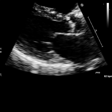

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/1777s1_18.png, GT: early AS
Method Default, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.21512712 0.28480089 0.50007199]
Method LE=1, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.21161491 0.34471979 0.4436653 ]


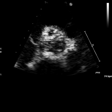

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/1139s1_13.png, GT: significant AS
Method Default, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.05003815 0.82879312 0.12116872]
Method LE=1, classes = ['no AS' 'significant AS'], confidences = [0.7162996  0.22103664]


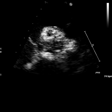

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/1139s1_24.png, GT: significant AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.93695869 0.05663502]
Method LE=1, classes = ['no AS' 'significant AS'], confidences = [0.69076946 0.21313746]


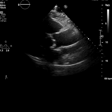

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/5868s1_2.png, GT: significant AS
Method Default, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.27643841 0.49432087 0.22924072]
Method LE=1, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.20525341 0.54982006 0.24492653]


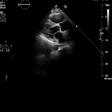

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/5868s1_4.png, GT: significant AS
Method Default, classes = ['early AS'], confidences = [0.99839183]
Method LE=1, classes = ['early AS'], confidences = [0.84388717]


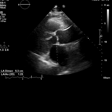

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/5868s1_5.png, GT: significant AS
Method Default, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.01280262 0.74484483 0.24235255]
Method LE=1, classes = ['early AS'], confidences = [0.90907486]


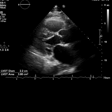

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/5868s1_7.png, GT: significant AS
Method Default, classes = ['no AS'], confidences = [0.99710677]
Method LE=1, classes = ['early AS'], confidences = [0.85191197]


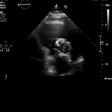

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/5868s1_8.png, GT: significant AS
Method Default, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.02972872 0.92467236 0.04559892]
Method LE=1, classes = ['early AS'], confidences = [0.89792375]


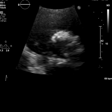

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/5868s1_9.png, GT: significant AS
Method Default, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.76953017 0.11175605 0.11871378]
Method LE=1, classes = ['no AS' 'early AS'], confidences = [0.43584254 0.47248473]


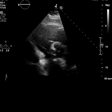

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/5868s1_10.png, GT: significant AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.96110494 0.03883916]
Method LE=1, classes = ['early AS'], confidences = [0.91081602]


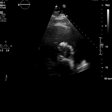

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/5868s1_11.png, GT: significant AS
Method Default, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.5304636  0.02908243 0.44045397]
Method LE=1, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.2051162  0.53209465 0.26278915]


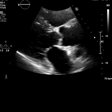

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/5868s1_15.png, GT: significant AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.9560366  0.04339406]
Method LE=1, classes = ['early AS'], confidences = [0.85790978]


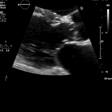

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/5868s1_21.png, GT: significant AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.60239913 0.3972903 ]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.63699801 0.27555453]


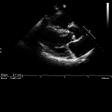

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/4864s1_0.png, GT: significant AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.96412535 0.03587085]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.71940149 0.18286341]


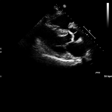

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/4864s1_3.png, GT: significant AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.98030861 0.01968885]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.6407588  0.31734685]


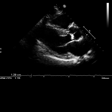

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/4864s1_4.png, GT: significant AS
Method Default, classes = ['early AS'], confidences = [0.99236668]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.60698135 0.31281305]


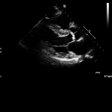

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/4864s1_10.png, GT: significant AS
Method Default, classes = ['early AS'], confidences = [0.99850174]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.61342281 0.31519327]


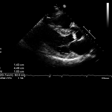

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/4864s1_20.png, GT: significant AS
Method Default, classes = ['early AS'], confidences = [0.99863549]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.71679891 0.21518904]


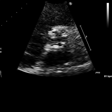

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/2010s1_5.png, GT: significant AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.85014631 0.14970895]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.56305047 0.40386259]


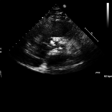

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/2010s1_13.png, GT: significant AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.96913211 0.03086654]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.7085782  0.25132601]


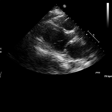

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/2398s1_6.png, GT: significant AS
Method Default, classes = ['no AS' 'early AS'], confidences = [0.96780118 0.02623636]
Method LE=1, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.31967511 0.48126215 0.19906273]


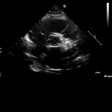

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/2398s1_13.png, GT: significant AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.98258277 0.01390164]
Method LE=1, classes = ['no AS' 'early AS'], confidences = [0.35777357 0.50791175]


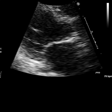

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/2398s1_32.png, GT: significant AS
Method Default, classes = ['no AS' 'significant AS'], confidences = [0.97413226 0.01919215]
Method LE=1, classes = ['no AS' 'significant AS'], confidences = [0.74162087 0.19692827]


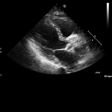

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/4098s1_0.png, GT: early AS
Method Default, classes = ['significant AS'], confidences = [0.9913015]
Method LE=1, classes = ['no AS' 'early AS' 'significant AS'], confidences = [0.54194835 0.2441466  0.21390505]


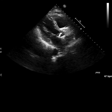

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/4098s1_1.png, GT: early AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.03372751 0.96625185]
Method LE=1, classes = ['significant AS'], confidences = [0.78651308]


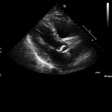

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/4098s1_2.png, GT: early AS
Method Default, classes = ['significant AS'], confidences = [0.99738386]
Method LE=1, classes = ['significant AS'], confidences = [0.76774903]


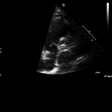

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/4098s1_3.png, GT: early AS
Method Default, classes = ['early AS' 'significant AS'], confidences = [0.02141231 0.97857576]
Method LE=1, classes = ['significant AS'], confidences = [0.81910693]


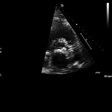

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/4098s1_10.png, GT: early AS
Method Default, classes = ['significant AS'], confidences = [0.98969732]
Method LE=1, classes = ['early AS' 'significant AS'], confidences = [0.23455144 0.62825928]


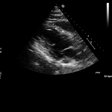

Name: /data/TMED/approved_users_only/view_and_diagnosis_labeled_set/labeled/3924s1_3.png, GT: significant AS
Method Default, classes = ['no AS' 'significant AS'], confidences = [0.9281687  0.06943182]
Method LE=1, classes = ['no AS'], confidences = [0.78596741]


In [22]:
def plot_tmed_inference(index):
    name = df_test_filtered[0]['filename'][index]
    get_TMED_image_by_id(name)
    show_inference_data(index, True)
    

count = 0
for i in selected:
    if count < 50:
        plot_tmed_inference(i)
        count += 1 

## study-level analysis

In [23]:
# create data structures where the studies are grouped and cines are arranged by view
def studyinfo_from_query_key(s):
    # Define the regular expression pattern
    pattern = r'(\d+)s(\d+)_(\d+)\.png'
    
    # Use re.match to search for the pattern in the string
    match = re.match(pattern, s)
    
    # If a match is found, extract the groups and return them as a tuple
    if match:
        ID, studyNum, imageNum = match.groups()
        #return int(ID), int(studyNum), int(imageNum)
        return str(ID) + '_' + str(studyNum)
    else:
        return None
    
def find_study_id(uids, mode='TMED'):
    # uids is a pd.series of unique identifiers
    # returns a pd.series of study IDs
    basenames = uids.apply(os.path.basename)
    study_nums = basenames.apply(studyinfo_from_query_key)
    return study_nums

def create_study_groups(df, df_view):
    output_cols = [x for x in df.columns if 'preds' in x]
    output_cols_view = [x for x in df_view.columns if 'preds' in x]
    study_nums = find_study_id(df['filename'])
    studies = {}
    for uid in study_nums.unique():
        studies[uid] = {}
        study_filenames = df[study_nums == uid]['filename'].to_numpy()
        study_diagnosis_preds = df[study_nums == uid][output_cols].to_numpy()
        study_view_preds = df_view[study_nums == uid][output_cols_view].to_numpy()
        study_y = df[study_nums == uid]['y'].to_numpy()
        studies[uid]['filenames'] = study_filenames
        studies[uid]['preds'] = study_diagnosis_preds
        studies[uid]['view_preds'] = study_view_preds
        studies[uid]['y'] = int(study_y[0])
        
    return studies

studies = []
studies_val = []
for i in range(len(methods)):
    studies.append(create_study_groups(df_test[i], df_view_test))
    studies_val.append(create_study_groups(df_val[i], df_view_val))

In [24]:
def aggregate_study_pred(preds, view_preds):
    # (N, C) preds [0,1], (N, C_view) view_preds [0,1]
    key_views = [2,3] # these view IDs correspond to PLAX, PSAX
    key_view_confidence = np.sum(view_preds[:, key_views], axis=1)
    view_scaled_confidence = preds * key_view_confidence[:, np.newaxis]
    aggregated_confidence = view_scaled_confidence.sum(axis=0) / np.sum(key_view_confidence)
    return aggregated_confidence

def process_all_study_preds(studies_dict):
    preds_list = []
    gts_list = []
    for k in studies_dict.keys():
        entry = studies_dict[k]
        preds_list.append(aggregate_study_pred(entry['preds'], entry['view_preds']))
        gts_list.append(entry['y'])
    return np.array(preds_list), np.array(gts_list)
    
test_preds_study_level = [] 
test_y_study_level = []
val_preds_study_level = []
val_y_study_level = []
for i in range(len(methods)):
    preds, gts = process_all_study_preds(studies[i])
    test_preds_study_level.append(preds)
    test_y_study_level.append(gts)
    
    preds, gts = process_all_study_preds(studies_val[i])
    val_preds_study_level.append(preds)
    val_y_study_level.append(gts)
    

In [25]:
# compute the top-1 balanced accuracy
for i in range(len(methods)):
    test_gt = test_y_study_level[i]
    test_pred = np.argmax(test_preds_study_level[i], axis=1)
    
    test_acc = balanced_accuracy_score(test_gt, test_pred)
    print(f"Method: {methods[i]}, balanced top-1 acc = {test_acc}")
    print(confusion_matrix(test_gt, test_pred))

Method: Default, balanced top-1 acc = 0.7324183006535948
[[19  3  3]
 [ 8 16 10]
 [ 0  2 58]]
Method: LE=1, balanced top-1 acc = 0.7422222222222222
[[19  1  5]
 [ 8 17  9]
 [ 0  2 58]]


In [26]:
# Conformal prediction using LABEL
for i in range(len(methods)):
    print(methods[i])
    y_test = test_y_study_level[i]
    y_val = val_y_study_level[i]
    
    val_sm = val_preds_study_level[i]
    test_sm = test_preds_study_level[i]
    
    print(np.unique(y_test))
    
    cov, bcov, card = develop_coverage_distribution(y_test, test_sm, n_splits=100, test_size=0.7, alpha=0.1)
    
    print(f"cov: {np.median(cov)}, {np.std(cov)}")
    print(f"bcov: {np.median(bcov)}, {np.std(bcov)}")
    print(f"card: {np.median(card)}, {np.std(card)}")
    
#     alphas = [0.1]
#     for a in alphas:
#         qhat = LABEL_fit(y_val, val_sm, alpha=a, verbose=False)
#         cs = LABEL_inference(test_sm,  qhat)

#         cov = coverage_test(y_test, cs)
#         bcov = balanced_coverage_test(y_test, cs)
#         card = cardinality_test(cs)
#         if dataset != 'CIFAR':
#             print(ordinality_test_arr(cs))
#         print(f"Method {methods[i]} alpha={a}: cov={cov}, bcov={bcov}, card={card}, efficiency={bcov/card}")

Default
[0 1 2]
cov: 0.9047619047619048, 0.05863273504662407
bcov: 0.8899607839825231, 0.06493170893128397
card: 1.8571428571428572, 0.33133679284797907
LE=1
[0 1 2]
cov: 0.9285714285714286, 0.0556216160528944
bcov: 0.9184203736292977, 0.06172014179262875
card: 2.136904761904762, 0.33934001236360223
